Running Adversarial Neuron Pruning

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load dataset

In [4]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify dataset

In [6]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9

In [7]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [8]:
# create a subset of the dataset
l = len(cifar10_train)
indices = np.arange(l)

In [9]:
np.random.seed(594462)
np.random.shuffle(indices)

# since we use 0.9 of the set as backdoored training set, we will use the rest 0.1 as fixing set
keep_indices = indices[int(l * poisoned_set_ratio):]

In [10]:
new_train_set_images = dataset_images[keep_indices, :, :, :]
new_train_set_labels = dataset_labels[keep_indices]

In [11]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(new_train_set_images), torch.tensor(new_train_set_labels))

In [12]:
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=125, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

### Create and load the ResNet18

In [13]:
num_classes = 10

In [14]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()
res18.fc = torch.nn.Linear(res18.fc.in_features, num_classes).cuda() if torch.cuda.is_available() else torch.nn.Linear(res18.fc.in_features, num_classes)

In [15]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [16]:
res18.load_state_dict(torch.load(f'saved_models/ResNet18-CIFAR10-backdoored-5-Epoch-200.pth'))

C:\Users\Kevvol\AppData\Local\Temp\ipykernel_8748\3783847679.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res18.load_state_dict(torch.load(f'saved_models/ResNet18-CIF

<All keys matched successfully>

### Create ANP wrapper

In [17]:
from ANP import *

In [18]:
anp_system = ANPWrapper(res18, tradeoff=0.2, lr=0.005, ep=0.6)

In [19]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [20]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    pxl_w = torch.tensor((1.0, 1.0, 1.0))
    pxl_b = torch.tensor((0.0, 0.0, 0.0))
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [21]:
test_acc_list = []
asr_list = []

# train for this many epochs
for epoch in range(50):
    anp_system.model.train()
    
    i = 0
    total_weight_masks_loss = 0
    for inputs, label in train_loader:
        inputs, label = inputs.to(device), label.to(device)
        # perform perturb step
        weight_masks_loss = anp_system.perturb_step(inputs, label)
        total_weight_masks_loss += weight_masks_loss
        # print(f'epoch: {epoch} | iteration: {i} | weight_mask_loss: {weight_masks_loss}')
        i += 1
    print(f'epoch: {epoch} | total_weight_masks_loss: {total_weight_masks_loss}')

    # in eval mode, we test backdoor effectiveness
    anp_system.model.eval()
    
    # testing loop (normal data)
    total_test_acc = 0
    test_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = anp_system.model(inputs)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    test_acc_list.append(total_test_acc/test_item_ct)
    
    # test with backdoor inserted to training set images
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = anp_system.model(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            backdoor_success_ct += np.sum(pred_lbls == 0)
            backdoor_item_ct += inputs.shape[0]
    
    print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    asr_list.append(backdoor_success_ct/backdoor_item_ct)

epoch: 0 | total_weight_masks_loss: 273.7279298454523
Test Accuracy: 0.6609
Backdoor Success Rate: 0.1916
epoch: 1 | total_weight_masks_loss: 277.48786336928606
Test Accuracy: 0.6856
Backdoor Success Rate: 0.1771
epoch: 2 | total_weight_masks_loss: 272.33329370617867
Test Accuracy: 0.6838
Backdoor Success Rate: 0.3607
epoch: 3 | total_weight_masks_loss: 270.38161370903254
Test Accuracy: 0.6943
Backdoor Success Rate: 0.2208
epoch: 4 | total_weight_masks_loss: 272.6984576880932
Test Accuracy: 0.6846
Backdoor Success Rate: 0.1289
epoch: 5 | total_weight_masks_loss: 269.6371750384569
Test Accuracy: 0.6584
Backdoor Success Rate: 0.465
epoch: 6 | total_weight_masks_loss: 267.8653917238116
Test Accuracy: 0.645
Backdoor Success Rate: 0.1175
epoch: 7 | total_weight_masks_loss: 272.68597289174795
Test Accuracy: 0.6317
Backdoor Success Rate: 0.1643
epoch: 8 | total_weight_masks_loss: 271.54538118839264
Test Accuracy: 0.6584
Backdoor Success Rate: 0.1214
epoch: 9 | total_weight_masks_loss: 267.939

In [22]:
import matplotlib.pyplot as plt

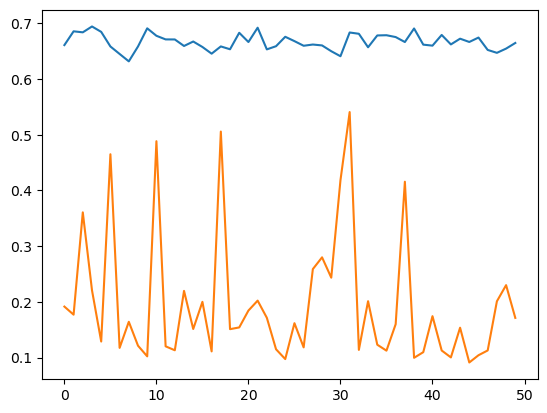

In [23]:
plt.plot(test_acc_list)
plt.plot(asr_list)